In [ ]:
import numpy as np
import pandas as pd
import cv2
from torch.utils.data import random_split, DataLoader
from torchvision.models import vgg19
import tqdm
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import os
from brisque import BRISQUE
from dataset import EXRDataset
import torch.nn.functional as F

In [2]:
# enable using OpenEXR with OpenCV
os.environ['OPENCV_IO_ENABLE_OPENEXR'] = "1"

FILE_PATH = os.path.normpath("./data/reference/001.exr")

def read_exr(im_path: str) -> np.ndarray:
    return cv2.imread(
    filename=im_path,
    flags=cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH
    )
def tone_map_reinhard(image: np.ndarray) -> np.ndarray:
    tonemap_operator = cv2.createTonemapReinhard(
    gamma=2.2,
    intensity=0.0,
    light_adapt=0.0,
    color_adapt=0.0
    )
    result = tonemap_operator.process(src=image)
    return result
def tone_map_mantiuk(image: np.ndarray) -> np.ndarray:
    tonemap_operator = cv2.createTonemapMantiuk(
    gamma=2.2,
    scale=0.85,
    saturation=1.2
    )
    result = tonemap_operator.process(src=image)
    return result

def evaluate_image(image: np.ndarray) -> float:
    metric = BRISQUE(url=False)
    return metric.score(img=image)

def fix_colors(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def clip(img):
    return np.clip(img / np.max(img), 0, 1)

In [3]:
# image = read_exr(im_path=FILE_PATH)
# tone_mapped_reinhard = tone_map_reinhard(image)
# tone_mapped_mantiuk = tone_map_mantiuk(image)

# fig, axes = plt.subplots(1, 3, figsize=(10, 5)) 

# axes[0].imshow(fix_colors(clip(image)))
# axes[0].axis('off')
# axes[0].set_title("original")

# axes[1].imshow(fix_colors(tone_mapped_reinhard))
# axes[1].axis('off')
# axes[1].set_title("tone_mapped_reinhard")

# axes[2].imshow(fix_colors(tone_mapped_mantiuk))
# axes[2].axis('off')
# axes[2].set_title("tone_mapped_mantiuk")

# print('tone_mapped_reinhard', evaluate_image(image=tone_mapped_reinhard))
# print('tone_mapped_mantiuk', evaluate_image(image=tone_mapped_mantiuk))

# 3.1 Multiple Exposure Selection

In [4]:
def aces_estimation(t=0.85, A=2.51, B=0.03, C=2.43, D=0.59, E=0.14):
    # (tC - A)x^2 + (tD - B)x + tE = 0
    a = t * C - A
    b = t * D - B
    c = t * E

    delta = b ** 2 - 4 * a * c
    return (-b - np.sqrt(delta)) / (2 * a)

def exposures(img: torch.Tensor):
    x_p = aces_estimation()

    c_start = torch.log(x_p / torch.max(img))

    percentile_50 = torch.quantile(img, 0.5)
    c_end = torch.log2(x_p / percentile_50)

    output_list = []
    exp_value = [c_start, (c_end + c_start) / 2.0, c_end]
    for value in exp_value:
        sc = torch.pow(torch.sqrt(torch.tensor(2.0)), value)
        img_exp = img * sc
        img_out = torch.clip(img_exp, 0, 1)
        output_list.append(img_out)

    return output_list

In [5]:
# def normalize(img):
#     return img * (0.5 / np.mean(img))

# img_low, img_mid, img_high = exposures(torch.from_numpy(normalize(image)))

# fig, axes = plt.subplots(1, 4, figsize=(10, 10)) 

# axes[0].imshow(fix_colors(normalize(image)))
# axes[0].axis('off')
# axes[0].set_title("I-src")


# axes[1].imshow(fix_colors(img_low.detach().cpu().numpy()))
# axes[1].axis('off')
# axes[1].set_title("I-e-low")

# axes[2].imshow(fix_colors(img_mid.detach().cpu().numpy()))
# axes[2].axis('off')
# axes[2].set_title("I-e-mid")

# axes[3].imshow(fix_colors(img_high.detach().cpu().numpy()))
# axes[3].axis('off')
# axes[3].set_title("I-e-high")

# 3.2 Tone Mapping Network

In [6]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.decoder = nn.Sequential(
            nn.Conv2d(192, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 3, kernel_size=3, stride=1, padding=1),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, exp1, exp2, exp3):
        x = self.decoder(x)
        residual = x + exp1 + exp2 + exp3
        return self.sigmoid(residual)
    

class SelfTMO(nn.Module):
    def __init__(self):
        super(SelfTMO, self).__init__()

        # 1 instance of encoder to share the weights
        self.encoder = Encoder()
        
        self.fusion = nn.Sequential(
            nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(192, 192, kernel_size=1, stride=1)
        )

        self.decoder = Decoder()

    def forward(self, exp1, exp2, exp3):
        exp1_enc = self.encoder(exp1)
        exp2_enc = self.encoder(exp2)
        exp3_enc = self.encoder(exp3)

        concat = torch.concat([exp1_enc, exp2_enc, exp3_enc], axis = 1)
        
        concat = self.fusion(concat)
        concat = self.decoder(concat, exp1, exp2, exp3)

        return concat

# 3.3 Adaptive μ-law compression

In [7]:
def mi_law(input, lambda1=8.759, lambda2=0.1494, gamma1=2.148, gamma2=-2.067):
    return lambda1 * (input ** gamma1) + lambda2 * (input ** gamma2)

def mi_img(img: np.ndarray):
    law_value = mi_law(img)
    return torch.log(1+law_value*img)/torch.log(1+law_value)

# 3.4 Feature Contrast Masking Loss

# Training

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print(device)

cuda


In [9]:
model_vgg19 = vgg19(pretrained=True).features[:18].to(device)
model_vgg19.eval()

def feature_contrast(feature_map, patch_size=13, epsilon=1e-4):
    kernel = torch.ones(feature_map.shape[1], 1, patch_size, patch_size, device=feature_map.device) / (patch_size ** 2)
    
    gauss = F.conv2d(feature_map, kernel, padding=patch_size//2, groups=feature_map.shape[1])
    
    return (feature_map - gauss) / (torch.abs(gauss) + epsilon)


def feature_contrast_self_masking(feature_map, alpha):  # mi: alpha=0.5, TM: alpha=1
    C = feature_contrast(feature_map)
    return torch.sign(C)*torch.abs(C)**alpha


def feature_contrast_neighborhood_masking(feature_map, patch_size=13, epsilon=1e-4):
    kernel = torch.ones((feature_map.shape[1], 1, patch_size, patch_size), dtype=torch.float32, device=feature_map.device) / (patch_size ** 2)
    
    mi_b = F.conv2d(feature_map, kernel, padding=patch_size//2, groups=feature_map.shape[1])
    
    feature_map_squared = feature_map ** 2
    mi_b_squared = F.conv2d(feature_map_squared, kernel, padding=patch_size//2, groups=feature_map.shape[1])
    
    sigma_b = torch.sqrt(mi_b_squared - mi_b ** 2 + epsilon)
    
    contrast_map = sigma_b / (torch.abs(mi_b) + epsilon)
    
    return contrast_map.squeeze(0)

    
def f(Ms, Mn):
    return Ms / (1+Mn)

def loss(I_mi, I_tm):
    mi_vgg = model_vgg19(I_mi)
    tm_vgg = model_vgg19(I_tm)
    return torch.abs(
        f(feature_contrast_self_masking(mi_vgg, 0.5), feature_contrast_neighborhood_masking(mi_vgg)) - 
        f(feature_contrast_self_masking(tm_vgg, 1), feature_contrast_neighborhood_masking(tm_vgg))
    )

/home/tomek/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tomek/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
model = SelfTMO()
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0002)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [12]:
dataset = EXRDataset("./data/processed")

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [ ]:
num_epochs = 400
losses = {"train":[],"val":[]}

for epoch in range(num_epochs):
    model.train()
    for img in tqdm.tqdm(train_loader):
        optimizer.zero_grad()

        img = img.to(device)

        img_low, img_mid, img_high = exposures(img)

        I_tm = model(img_low, img_mid, img_high)
        I_mi = mi_img(img)

        a = loss(I_mi, I_tm).mean()

        a.backward()
        optimizer.step()
    
    model.eval()
    print(f"epoch #{epoch+1}, loss: {a}")
    losses["train"].append(a.item())
    with torch.no_grad():
        total_loss = 0.0
        for img in val_dataset:
            img = img.unsqueeze(0).to(device)
            img_low, img_mid, img_high = exposures(img)
            I_tm = model(img_low, img_mid, img_high)

            I_mi = mi_img(img)

            a = loss(I_mi, I_tm)
            total_loss += a.mean().item()
        print("Validation loss:",total_loss / len(val_dataset))
    losses["val"].append(total_loss)

    if (epoch + 1) % 10 == 0:
        scheduler.step()

100%|██████████| 80/80 [00:30<00:00,  2.66it/s]


epoch #1, loss: 0.16713298857212067
Validation loss: 0.18402069583535194


100%|██████████| 80/80 [00:29<00:00,  2.67it/s]


epoch #2, loss: 0.14280474185943604
Validation loss: 0.17202443778514862


100%|██████████| 80/80 [00:30<00:00,  2.66it/s]


epoch #3, loss: 0.1407468020915985
Validation loss: 0.16465560719370842


100%|██████████| 80/80 [00:30<00:00,  2.67it/s]


epoch #4, loss: 0.14719901978969574
Validation loss: 0.16150069870054723


100%|██████████| 80/80 [00:29<00:00,  2.67it/s]


epoch #5, loss: 0.12862147390842438
Validation loss: 0.1531732462346554


100%|██████████| 80/80 [00:30<00:00,  2.67it/s]


epoch #6, loss: 0.17945802211761475
Validation loss: 0.14594168215990067


100%|██████████| 80/80 [00:30<00:00,  2.66it/s]


epoch #7, loss: 0.11628665030002594
Validation loss: 0.1466050934046507


100%|██████████| 80/80 [00:30<00:00,  2.67it/s]


epoch #8, loss: 0.15516649186611176
Validation loss: 0.1514143381267786


100%|██████████| 80/80 [00:30<00:00,  2.66it/s]


epoch #9, loss: 0.09701389074325562
Validation loss: 0.14250366501510142


100%|██████████| 80/80 [00:30<00:00,  2.66it/s]


epoch #10, loss: 0.13834889233112335
Validation loss: 0.14137063268572092


100%|██████████| 80/80 [00:30<00:00,  2.66it/s]


epoch #11, loss: 0.1392056941986084
Validation loss: 0.14233214147388934


100%|██████████| 80/80 [00:30<00:00,  2.67it/s]


epoch #12, loss: 0.146929532289505
Validation loss: 0.1426632110029459


100%|██████████| 80/80 [00:30<00:00,  2.66it/s]


epoch #13, loss: 0.18569451570510864
Validation loss: 0.14057235531508921


100%|██████████| 80/80 [00:30<00:00,  2.66it/s]


epoch #14, loss: 0.10168895125389099
Validation loss: 0.13895469158887863


100%|██████████| 80/80 [00:30<00:00,  2.66it/s]


epoch #15, loss: 0.160171777009964
Validation loss: 0.1385607620701194


100%|██████████| 80/80 [00:30<00:00,  2.66it/s]


epoch #16, loss: 0.16552482545375824
Validation loss: 0.13922511134296656


100%|██████████| 80/80 [00:30<00:00,  2.66it/s]


epoch #17, loss: 0.14127066731452942
Validation loss: 0.13869875762611628


100%|██████████| 80/80 [00:30<00:00,  2.66it/s]


epoch #18, loss: 0.17316943407058716
Validation loss: 0.1384431730955839


100%|██████████| 80/80 [00:30<00:00,  2.65it/s]


epoch #19, loss: 0.15414701402187347
Validation loss: 0.137473414093256


100%|██████████| 80/80 [00:30<00:00,  2.66it/s]


epoch #20, loss: 0.1372152417898178
Validation loss: 0.13745347037911415


In [16]:
def lum(img):
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]
    l = 0.2126 * r + 0.7152 * g + 0.0722 * b
    return l

def color_correction(img_in, img_out, s=0.6):
    l_in = lum(img_in)
    l_out = lum(img_out)

    l_in = l_in[..., np.newaxis]
    l_out = l_out[..., np.newaxis]

    return l_out * (img_in / l_in) ** s

In [ ]:
# torch.save(model, 'test.pth')
# torch.load('test.pth')

     Image  Tone Mapped Reinhard  Tone Mapped Mantiuk      Model
0  Image 0             54.973167            77.353004  40.550940
1  Image 1             35.593235            58.068831  13.979063
2  Image 2             17.922752           114.385498  77.189898
3  Image 3             29.181032             9.529539  18.659742


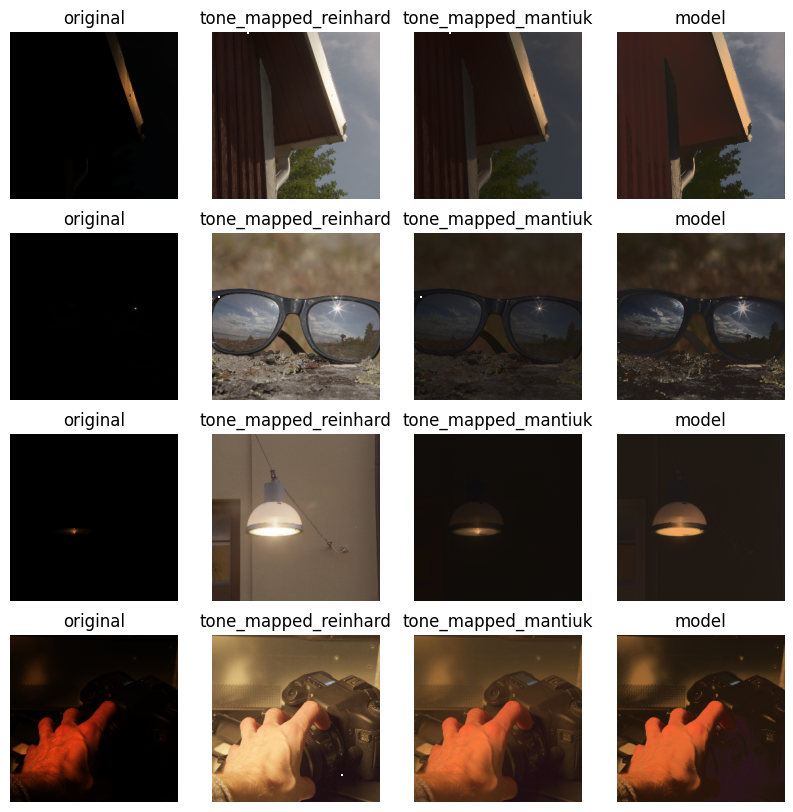

In [34]:
model.eval()

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
results = []

for i in range(4):
    image = val_dataset[i]
    image_org = clip(image.numpy().transpose(1, 2, 0))
    image = image.unsqueeze(0).to(device)

    img_low, img_mid, img_high = exposures(image)
    result = model(img_low, img_mid, img_high).squeeze(0)
    result = result.cpu().detach().numpy().transpose(1, 2, 0)

    tone_mapped_reinhard = tone_map_reinhard(image_org)
    tone_mapped_mantiuk = tone_map_mantiuk(image_org)
    result_corrected = clip(color_correction(image_org, result))

    axes[i, 0].imshow(fix_colors(image_org))
    axes[i, 0].axis('off')
    axes[i, 0].set_title("original")

    axes[i, 1].imshow(fix_colors(tone_mapped_reinhard))
    axes[i, 1].axis('off')
    axes[i, 1].set_title("tone_mapped_reinhard")

    axes[i, 2].imshow(fix_colors(tone_mapped_mantiuk))
    axes[i, 2].axis('off')
    axes[i, 2].set_title("tone_mapped_mantiuk")

    axes[i, 3].imshow(fix_colors(result_corrected))
    axes[i, 3].axis('off')
    axes[i, 3].set_title("model")

    eval_reinhard = evaluate_image(image=tone_mapped_reinhard)
    eval_mantiuk = evaluate_image(image=tone_mapped_mantiuk)
    eval_model = evaluate_image(image=result_corrected)

    results.append({
        'Image': f'Image {i}',
        'Tone Mapped Reinhard': eval_reinhard,
        'Tone Mapped Mantiuk': eval_mantiuk,
        'Model': eval_model
    })

print(pd.DataFrame(results))